In [34]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint
from antlia import trial2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    return IPython.display.HTML(animation.to_jshtml())

In [3]:
bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

i = 3 # rider
f1 = bicycle_record_files[i]
f2 = lidar_record_files[i]

with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

data_dir = '../../data/comfort/'
bicycle_rec = load_file(
    os.path.join(data_dir, f1),
    bicycle_calibration['convbike'])
lidar_rec = load_converted_record(
    os.path.join(data_dir, f2))

r = Record(lidar_rec, bicycle_rec)
r.sync()

-9.2400000000000091

In [4]:
r._calculate_trials2()

<IPython.core.display.Javascript object>


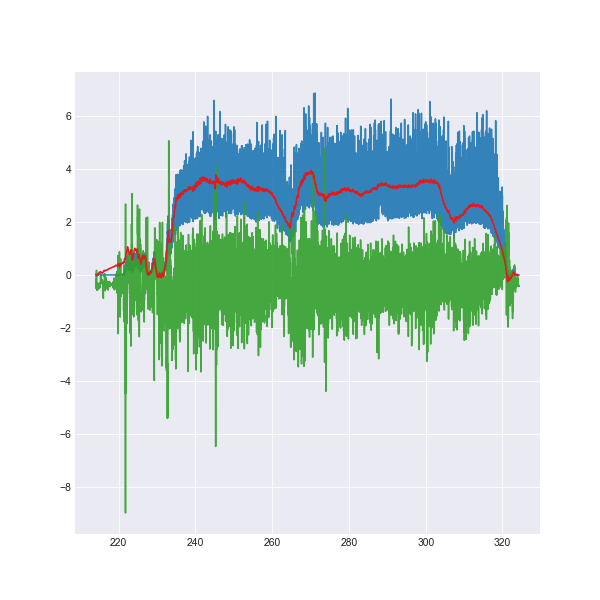

In [37]:
DEFAULT_FIGSIZE=(8, 8)
%matplotlib notebook

import scipy.integrate


def estimate_velocity(trial):
    x = trial.bicycle['accelerometer x']
    xm = x[:100].mean()
    v = scipy.integrate.cumtrapz(-(x - xm), dx=trial.period, initial=0)
    error = np.interp(trial.bicycle.time, trial.bicycle.time[[0, -1]], [0, v[-1]])
    return v - error

plt.close('all')
tr = r.trials[2]
color = sns.color_palette('Paired', 12)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
ax.plot(tr.bicycle.time,
        tr.bicycle.speed,
        alpha=0.9,
        color=color[1])
ax.plot(tr.bicycle.time,
        tr.bicycle['accelerometer x'],
        alpha=0.9,
        color=color[3])
ax.plot(tr.bicycle.time,
        estimate_velocity(tr),
        alpha=1,
        color=color[5])
plt.show()

In [86]:
def trajectory(lidarrec):
    """Calculate trajectory using a simple average of point position. The
    obstacle is excluded by means of a bounding box.
    """
    # determine obstacle
    x_obs = lidarrec.cartesian(
        xlim=(-5, -2),
        ylim=(2.70, 3.25))[0]
    
    x, y = lidarrec.cartesian(
        xlim=(-20, 60),
        ylim=(1.0, 3.5))
    
    x.mask = np.logical_or(x.mask, np.logical_not(x_obs.mask))
    y.mask = x.mask
    
    return x.mean(axis=1), y.mean(axis=1)

def trajectory_distance(x, y):
    assert x.shape == y.shape
    dx = np.diff(x)
    dy = np.diff(y)
    return np.sqrt(np.square(dx) + np.square(dy))

bb = {
    'xlim': (-20, 50),
    'ylim': (0.5, 3.5)
}

obstacle_bb = {
    'xlim': (-5, -2),
    'ylim': (2.7, 3.5)
}

<IPython.core.display.Javascript object>


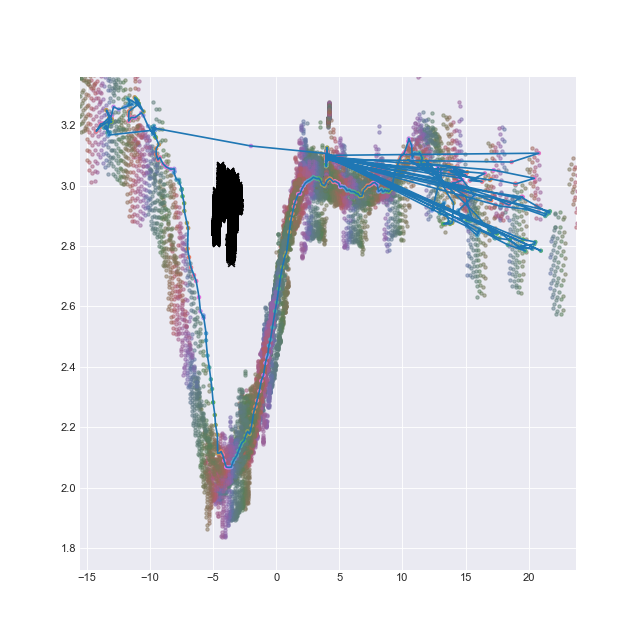

<IPython.core.display.Javascript object>


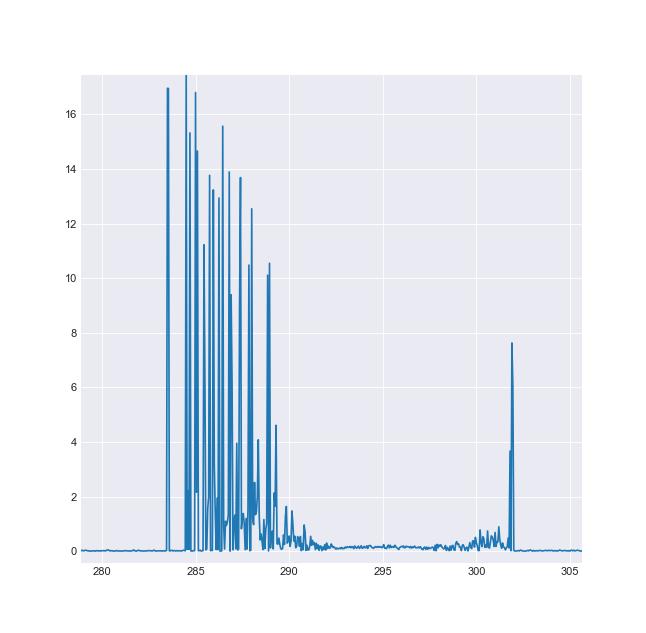

In [91]:
tr = r.trials[2]
lidarrec = tr.lidar[::1]

color = sns.husl_palette(20, s=0.4, l=0.5)
plt.close('all')
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

x, y = lidarrec.cartesian(**bb)
for i in range(x.shape[0]):
    c = color[i % len(color)]
    obs_mask = lidarrec.cartesian(**obstacle_bb)[0].mask
    x[i].mask = np.logical_or(x[i].mask, np.logical_not(obs_mask[i]))
    y[i].mask = np.logical_or(y[i].mask, np.logical_not(obs_mask[i]))
    ax.scatter(x[i].compressed(),
               y[i].compressed(),
               marker='.',
               alpha=0.5,
               color=c)
    
    x[i].mask = obs_mask[i]
    y[i].mask = obs_mask[i]
    ax.scatter(x[i].compressed(),
               y[i].compressed(),
               marker='x',
               color='black')

x, y = trajectory(lidarrec)

color = np.array(sns.husl_palette(20, s=0.7))
color = np.matlib.repmat(
    color,
    int(np.ceil(x.shape[0]/color.shape[0])),
    1)[:x.shape[0]]
ax.scatter(x, y, marker='.', c=color)
ax.plot(x, y)

ax.set_xlim(bb['xlim'])
ax.set_ylim(bb['ylim'])
 
    
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
d = trajectory_distance(x, y)
ax.plot(lidarrec.time[:-1], d)
    
plt.show()

<IPython.core.display.Javascript object>


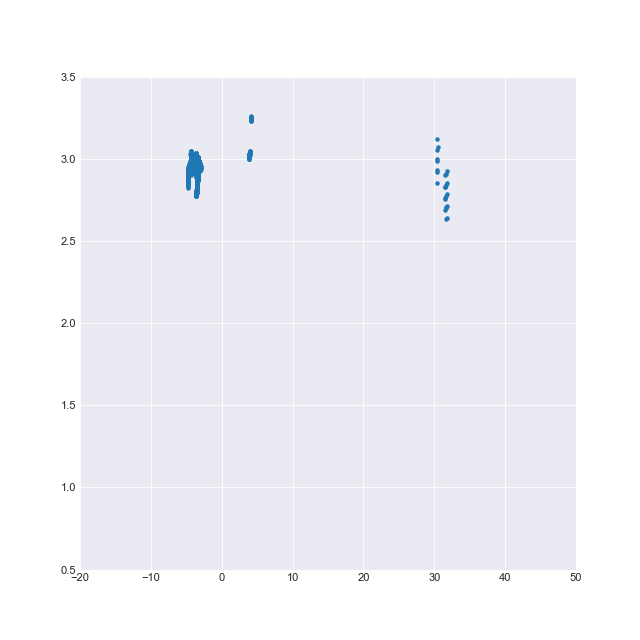

In [55]:
plt.close('all')
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
x, y = r.trials[2].event.lidar[40:50].cartesian(**trial2.VALID_BB)

ax.scatter(x.compressed(), y.compressed(), marker='.')
ax.set_xlim(bb['xlim'])
ax.set_ylim(bb['ylim'])
plt.show()